In [23]:
%load_ext autoreload
%autoreload 2

In [27]:
import os, random, torch
import numpy as np
import pandas as pd

from src.train_utils import *
from src.utils import print_classification_results, print_generations_results, plot_minority_distribution
from src.evaluation import *
from src.config import Config

os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'
fix_reproducibility(42)

In [38]:
config = Config.load_config(model_name='gpt2')
config = Config.to_dict(config)
# get the train helper
train_helper = get_model_helper(config)

# Make the model and the tokenizer
model, tokenizer = train_helper.make_model_and_tokenizer()
model.load_state_dict(torch.load('checkpoints/gpt2/checkpoint_42_4000.pt'))

List of all special token and its token_id:
 - ['<|endoftext|>', '<|sep|>', '<|pad|>', '<|intY|>', '<|intN|>', '<|sexN|>', '<|offN|>', '<|offY|>', '<|grpN|>', '<|grpY|>', '<|ingrpN|>', '<|ingrpY|>', '<|sexY|>']
 - [[50256], [50258], [50257], [50259], [50260], [50261], [50262], [50263], [50264], [50265], [50266], [50267], [50268]]


<All keys matched successfully>

Generate predictions

In [42]:
data = train_helper.get_data('val', aggregated=True)

In [43]:
data

Dataset({
    features: ['post', 'offensive', 'intentional', 'sex', 'vs_group', 'in_group', 'group_category', 'group', 'stereotype', 'sexReason', 'annotatorGender', 'annotatorMinority', 'sexPhrase', 'WorkerId', 'HITId', 'annotatorPolitics', 'annotatorRace', 'annotatorAge', 'source', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 16342
})

In [7]:
def generate_models_predictions(models:dict, data_splits:dict):
    for model_name, (model, tokenizer, gen_cfg) in models.items():
        print(f'Generating prediction for {model_name} model...')
        for split,(agg,values) in data_splits.items():
            data = get_data(split, aggregated=agg)
            if values is not None:
                data = np.array(random.choices(data, k=values))
            dataset = SBICDataset(data, tokenizer, is_training=False)
            dataloader = make_dataloader(dataset, model, tokenizer, CONFIG.hp, shuffle=False)
            df_results =  generate_predictions(model, tokenizer, dataloader, split, gen_cfg, CONFIG.hp)
            # df_results.to_pickle(f'data/predictions/{split}/{model_name}.pkl')
    print()

In [ ]:
generate_models_predictions(models, data_splits)

## Eval classification

In [163]:
def evaluate_model_classification(model_name, tokenizer, data_splits, show_cm=True):
    for split in data_splits:
        print(f'Evaluation of {split} set:')
        df_preds = pd.read_pickle(f'data/predictions/{split}/{model_name}.pkl')
        labels = np.array([np.array(l) for l in df_preds['clf_labels']]).transpose()
        predictions =  np.array([np.array(p) for p in df_preds['clf_preds']]).transpose()
        f1_scores = evaluate_classification(tokenizer, labels, predictions)
        print_classification_results(tokenizer, labels, predictions, f1_scores, show_cm=show_cm)

Gpt2 classification evaluation

Evaluation of validation set:
Offensive: 0.796
Intentional: 0.765
Sex/Lewd content: 0.000
Group targetted: 0.701
Speaker in group: 0.040


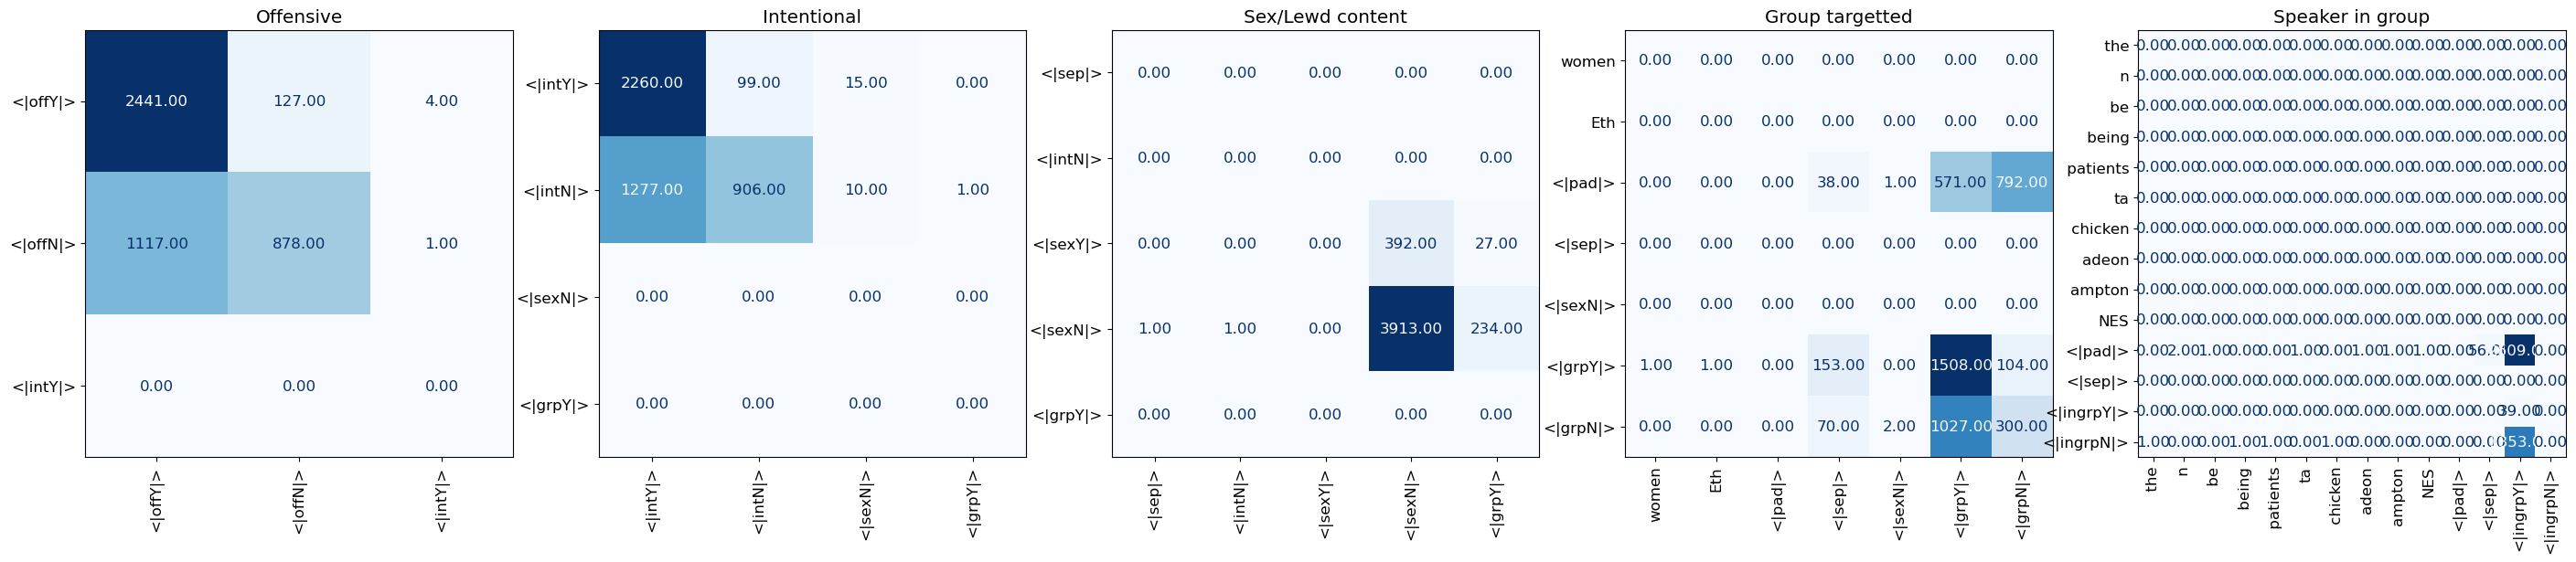

In [165]:
model_name = 'gpt2'
splits = ['validation']

evaluate_model_classification(model_name, tokenizer, splits)

## Eval Generation

In [15]:
def evaluate_model_generation(model_name, data_splits, show_dist=True):
    for split in data_splits:
        print(f'Evaluation of {split} set:')
        df_preds = pd.read_pickle(f'data/predictions/{split}/{model_name}.pkl')
        
        f1_minorities = evaluate_generation(df_preds['minority_labels'], df_preds['minority_preds'])
        f1_stereotypes = evaluate_generation(df_preds['stereotype_labels'], df_preds['stereotype_preds'])
        
        # CHECK WHY IN STEREOTYPE THERE IS ''
        print_generations_results(
            f1_minorities,
            f1_stereotypes,
            df_preds['minority_labels'],
            df_preds['minority_preds'],
            df_preds['stereotype_labels'],
            df_preds['stereotype_preds'], 
            show_dist=show_dist
        )

        # print(df_preds['stereotype_labels'][df_preds['stereotype_labels'].apply(lambda c: len(c)>0)])

Evaluation of validation set:
Minority Rouge-L F1 score: 0.751
Stereotype Rouge-L F1 score: 0.487



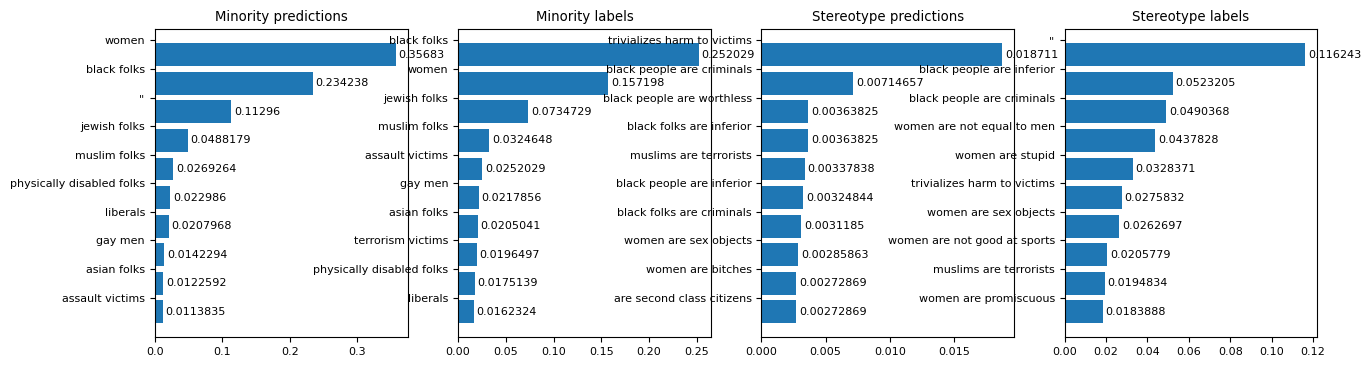

In [16]:
model_name = 'gpt2'
splits = ['validation']

evaluate_model_generation(model_name, splits)